**Aufgabe 21:**

Das folgende Anfangswertproblem modelliert die Reaktion dreier Spezies $x, y, z$:

\begin{align*}
    x^\prime(t) & = -0.04 x(t) + 10^4 y(t) z(t), \\
    y^\prime(t) & = 0.04 x(t) - 10^4 y(t) z(t) - 3 \cdot 10^7 y(t)^2, \\
    z^\prime(t) & = 3 \cdot 10^7 y(t)^2,
\end{align*}

mit Anfangswerten $x(0) = 1$, $y(0) = 0$, $z(0) = 0$ und $t \in [0, 1]$. Approximieren Sie die Lösung der Gleichung zunächst mit dem eingebetteten RK5(4) Verfahren mit verschiedenen Fehlertoleranzen und betrachten Sie die sich ergebenden Schrittweiten. Approximieren Sie nun die Lösung mit dem expliziten RK4 und dem impliziten Eulerverfahren. Versuchen Sie dabei die Schrittweiten zu optimieren. Beschreiben Sie Ihre Beobachtungen. Welches der verwendeten Verfahren erscheint Ihnen bei diesem Beispiel am effizientesten?

*Hinweis:* Sie können die im TUWEL zur Verfugung gestellten Programme verwenden.

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
# Functions from NumODEs_17.ipynb

def newton(F, DF, x_0, tol = 1e-6, t_max = 1e16):

    """
        This function implements the Newton-Method
        (from Nannen, Numerik A, Algorithmus 7.12).

        F ....... We search for x such that F(x) = 0.
        DF ...... Jacobian Matrix of F
        x_0 ..... where the iteration starts
        tol ..... tolerance for accuracy of F(x)
        t_max ... maximum iterations for Newton-Method
    """

    x = [x_0]
    Delta_x = [np.linalg.solve(DF(x[0]), -F(x[0]))]
    x += [x[0] + Delta_x[0]]
    t = 0

    while True:

        t += 1
        Delta_x += [np.linalg.solve(DF(x[t]), -F(x[t]))]
        x += [x[t] + Delta_x[t]]

        q_t = np.linalg.norm(Delta_x[t]) / np.linalg.norm(Delta_x[t-1])

        if q_t >= 1:
            print("STOP: Newton-Verfahren konvergiert nicht.")
            return None

        if q_t / (1 - q_t) * np.linalg.norm(Delta_x[t]) <= tol or t > t_max:
            return x[t+1]

def implicit_euler(t, y_0, f, f_y, tol = 1e-6, counter_max = 1e16):

    """
        This function implements the implicit Euler-Method.

        t ............. time steps
        y_0 ........... initial value at t_0 for solution
        f ............. right hand side
        f_y............ derivative with respect to y of right hand side
        tol ........... tolerance for accuracy of F(x)
        counter_max ... maximum iterations for Newton-Method
    """

    # dimension of range of f
    n = len(y_0)

    # t = t_0, ..., t_N
    N = len(t) - 1

    # distance between time steps
    h = t[1::] - t[:-1:]

    # approximated solution
    y = [y_0]

    for ell in range(N):

        F_ell  = lambda y_new: y_new - (y[-1] + h[ell] * f(t[ell+1], y_new))
        DF_ell = lambda y_new: np.eye(n, n) - h[ell] * f_y(t[ell+1], y_new)

#         guess = y[-1]
        guess = y[-1] + h[ell] * f(t[ell], y[-1])

#         y_new = newton(F_ell, DF_ell, guess, tol, counter_max)
        y_new = fsolve(F_ell, guess, xtol = tol)

        y += [y_new]

    y = np.array(y).transpose()

    return y

def practical_adaptive_algorithm(t_0, T, y_0, f, c, A, b_1, b_2, p, tau, h, h_min, lambda_, rho):

    """
        This function implements the Practical adaptive algorithm
        (from Nannen, Numerics of differential equations, Algorithm 2.35).

        t_0 ... lower bound of interval [t_0, T]
        T ..... upper bound of interval [t_0, T]
        y_0 ... initial value
        f ..... right hand side

        c, A, b_1 ... butcher tableau of           explicit runge-kutta one-step method of order p
        c, A, b_2 ... butcher tableau of auxiliary explicit runge-kutta one-step method of order p+1
        p ........... -

        tau ....... tolerance
        h ......... initial time-step size
        h_min ..... minimal time-step size
        lambda_ ... conformity factor
        rho ....... safety factor
    """

    m = len(c)

    t = [t_0]
    y = [y_0]
    h_array = [0]

    print("initiating practical adaptive algorithm ...", "\n")
    start = timer()

    print("current status ...", round(t[-1]/T * 100, 2), "%")
    print("current time .....", round(timer() - start), "sec")
    print("")
    stop = timer()

    while True:

        # status update each second
        if timer() - stop >= 1:
            print("current status ...", round(t[-1]/T * 100, 2), "%")
            print("passed time ......", round(timer() - start), "sec")
            print("")
            stop = timer()

        h = min(T - t[-1], max(h_min, h))

        k = np.zeros((m, 3))

        for i in range(m):
            k[i] = f(t[-1] + c[i] * h, y[-1] + h * (A[i][:i] @ k[:i]))

        F_1 = b_1 @ k
        F_2 = b_2 @ k

        H  = rho * (tau / (np.linalg.norm(F_1 - F_2)))**(1/p) * h

        if h <= H or h <= h_min:

            t += [t[-1] + h]
            h_array += [h]
            y += [y[-1] + h * F_2]

            if t[-1] < T:
                h = min(H, lambda_ * h)

        else:
            h = min(H, h / lambda_)

        if t[-1] >= T:

            t = np.array(t)
            h = np.array(h_array)
            y = np.array(y).transpose()

            return t, h, y

In [3]:
def apply_practical_adaptive_algorithm(f, y_0, tol):

    """
        This function applies the Practical adaptive algorithm
        and returns the number of steps.

        f ..... right hand side
        y_0 ... initial value at t_0 for solution
        tol ... tolerance
    """

    t_0 = 0
    T   = 1

    rho = 0.7
    eta = 1.5

    tau   = tol
    h_min = 1e-10

    h = 1e-5

    # Butcher tableau - RK5(4)
    A  = np.array([[0,           0,          0,           0,        0,            0,        0   ],
                   [1    /5,     0,          0,           0,        0,            0,        0   ],
                   [3    /40,    9    /40,   0,           0,        0,            0,        0   ],
                   [44   /45,   -56   /15,   32   /9,     0,        0,            0,        0   ],
                   [19372/6561, -25360/2187, 64448/6561, -212/729,  0,            0,        0   ],
                   [9017 /3168, -355  /33,   46732/5247,  49 /176, -5103 /18656,  0,        0   ],
                   [35   /384,   0,          500  /1113,  125/192, -2187 /6784,   11 /84,   0   ]])
    b_1 = np.array([35   /384,   0,          500  /1113,  125/192, -2187 /6784,   11 /84,   0   ])
    b_2 = np.array([5179 /57600, 0,          7571 /16695, 393/640, -92097/339200, 187/2100, 1/40])
    c   = np.array([0,           1    /5,    3    /10,    4  /5,    8    /9,      1,        1   ])
    p   = 4

    t, h, y = practical_adaptive_algorithm(t_0, T, y_0, f, c, A, b_1, b_2, p, tau, h, h_min, eta, rho)

    # ---------------- #

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

    ax1.plot(t, y[0], label = "$x(t)$")
    ax1.plot(t, y[1], label = "$y(t)$")
    ax1.plot(t, y[2], label = "$z(t)$")

    ax1.legend()
    ax1.set_xlabel("$t$")

    ax1.grid(linestyle = ":")

    ax2.semilogy(t, h, '--', label = "Schrittweite", color = "black", linewidth = 1)
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("Schrittweite ($h$)")
    ax2.grid(linestyle = ':')

    plt.suptitle("Practical adaptive algorithm")

    plt.savefig("images" + "/" + "apply_practical_adaptive_algorithm - single - tol = {}.png".format(tol))
    plt.show()

    # ---------------- #

    fig = plt.figure(figsize = (15, 5))

    plt.plot(t, y[0] / max(y[0]), label = "$x(t)$")
    plt.plot(t, y[1] / max(y[1]), label = "$y(t)$")
    plt.plot(t, y[2] / max(y[2]), label = "$z(t)$")
    plt.plot(t, h    / max(h),    '--', label = "Schrittweite", color = "black", linewidth = 1)

    plt.legend()
    plt.xlabel("$t$")
    plt.ylabel("Relation to $|| \cdot ||_\infty$")
    plt.grid(linestyle = ':')

    plt.savefig("images" + "/" + "apply_practical_adaptive_algorithm - combined - tol = {}.png".format(tol))
    plt.show()

    # ---------------- #

    return h

In [4]:
def f(t, y):

    M = np.array([[-0.04,  1e4,  0  ],
                  [ 0.04, -1e4, -3e7],
                  [ 0,     0,    3e7]])
    v = np.array([y[0], y[1]*y[2], y[1]*y[1]])

    return M @ v

y_0 = np.array([1, 0, 0])

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 0.001 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



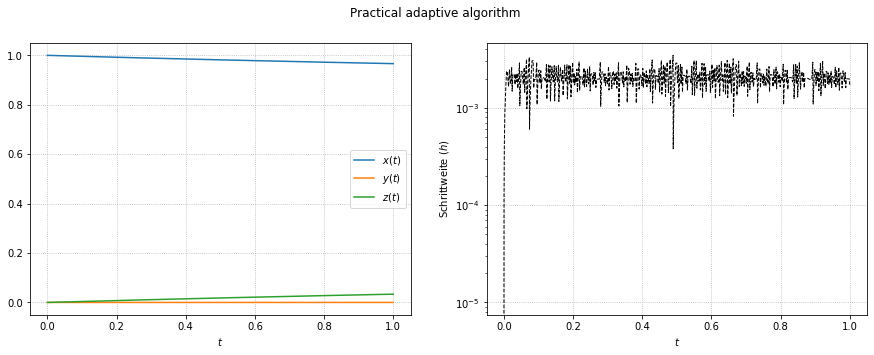

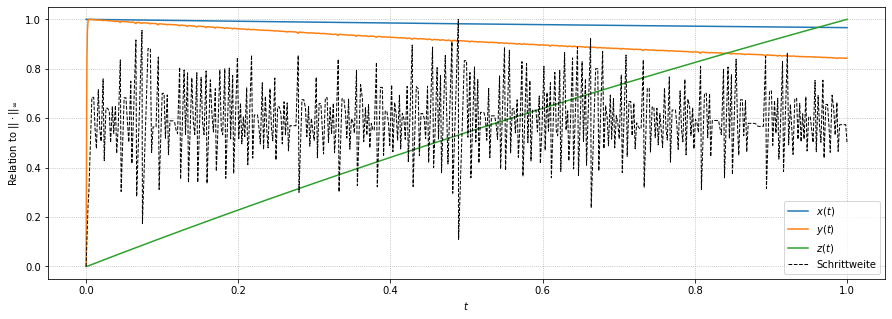

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 0.0001 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



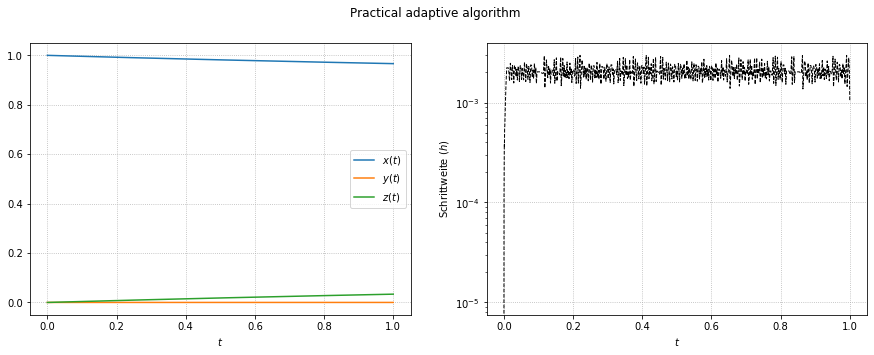

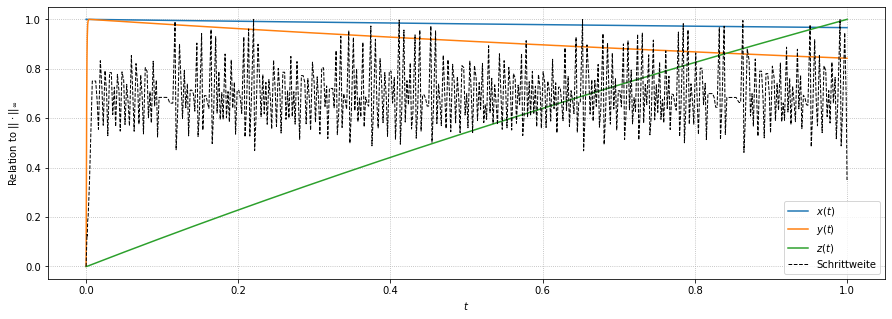

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-05 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



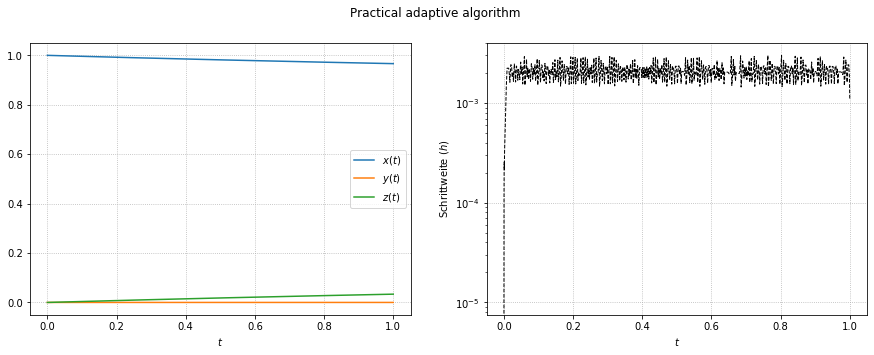

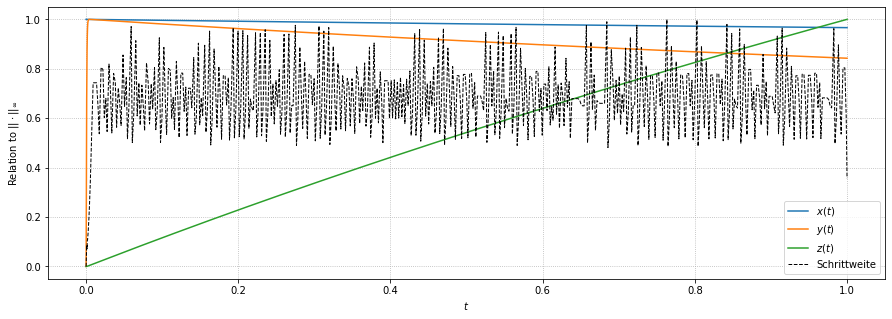

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-06 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



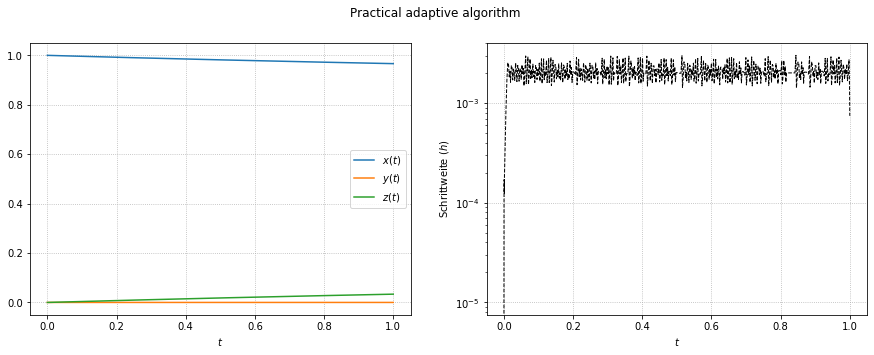

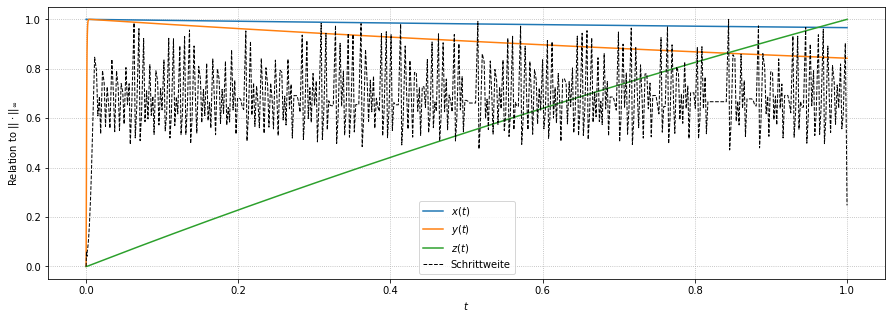

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-07 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



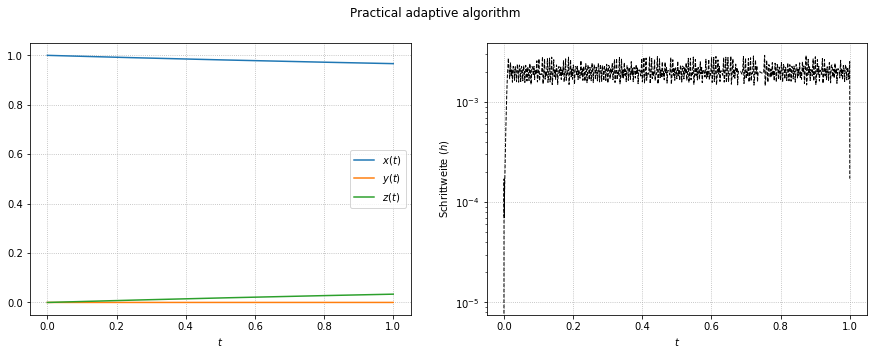

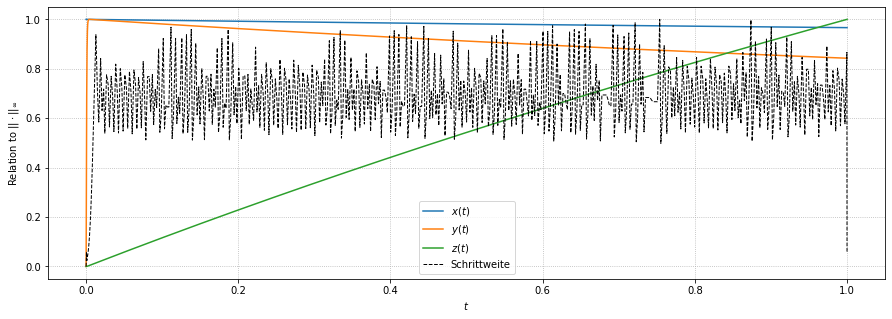

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-08 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



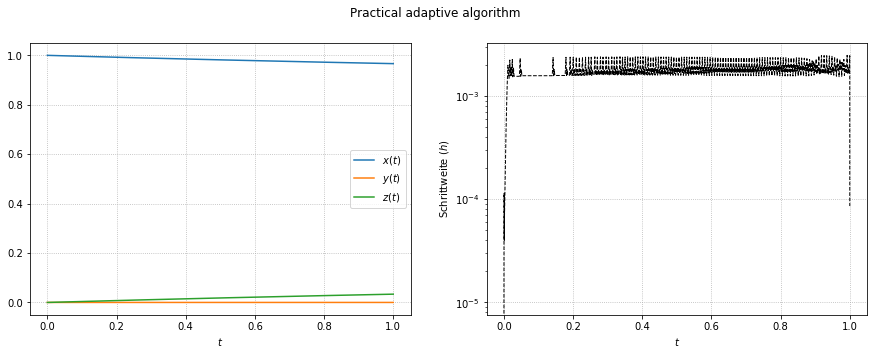

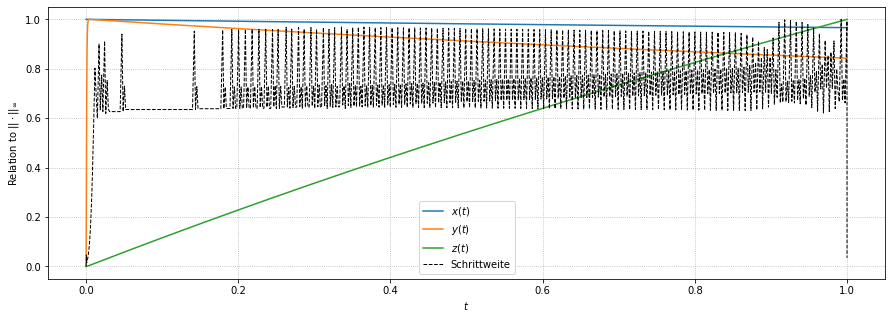

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-09 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



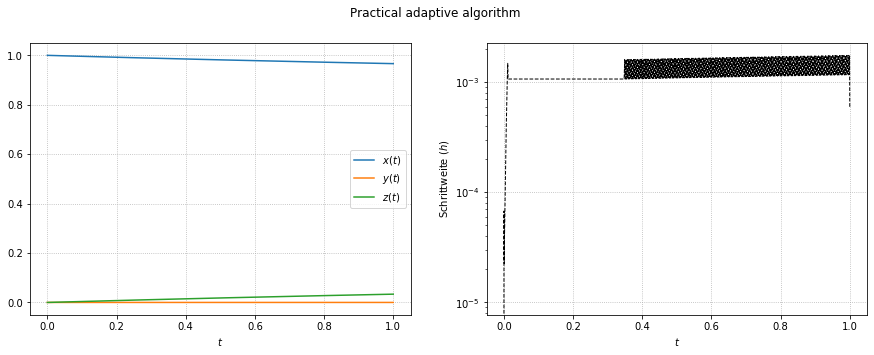

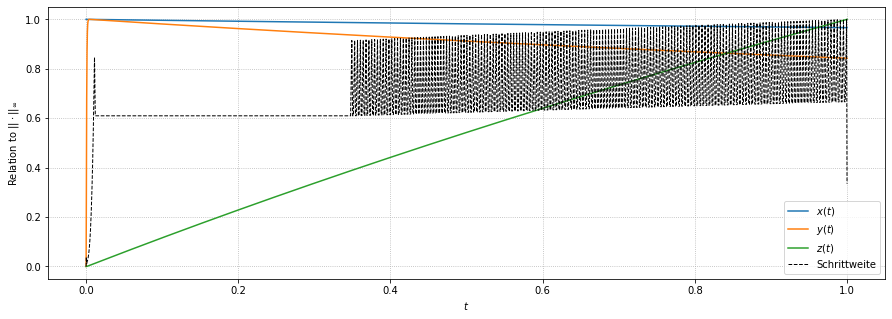

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-10 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



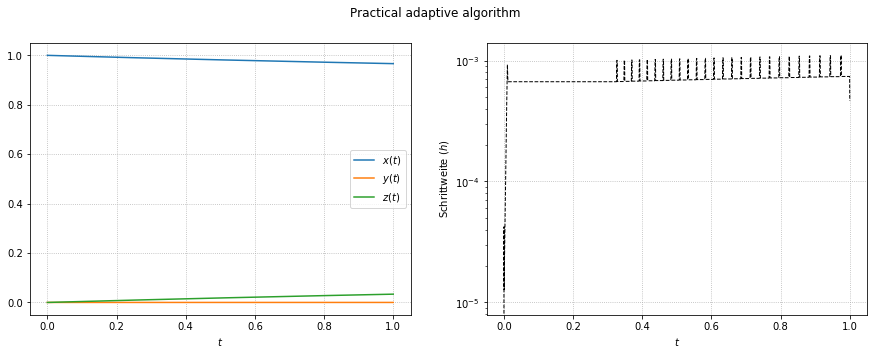

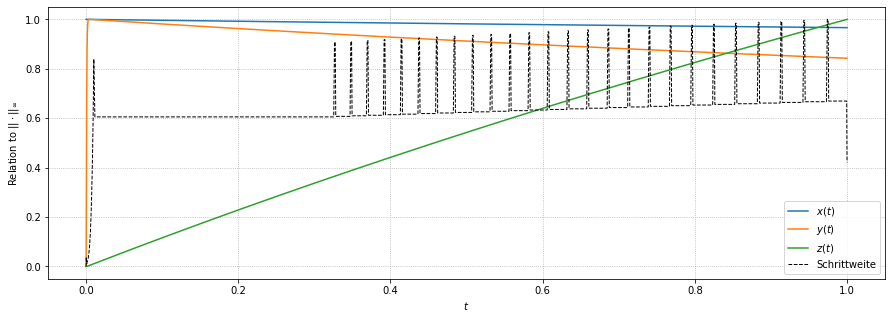

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-11 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



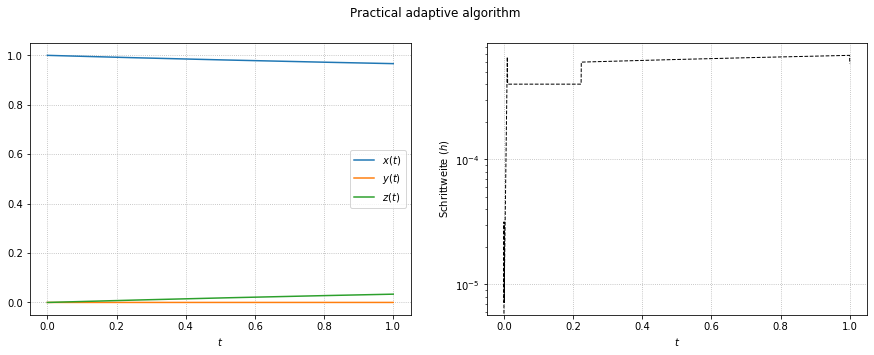

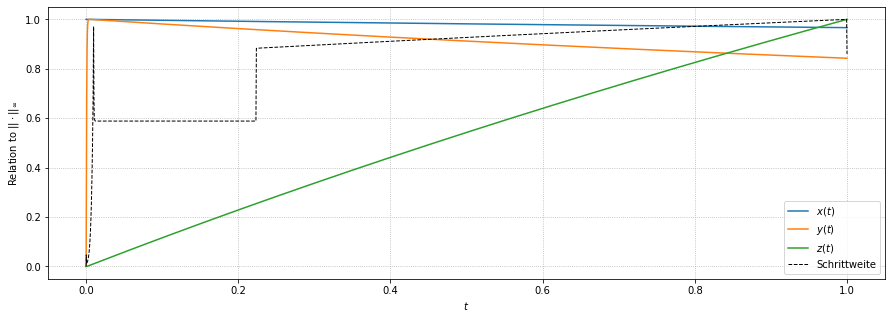

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-12 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



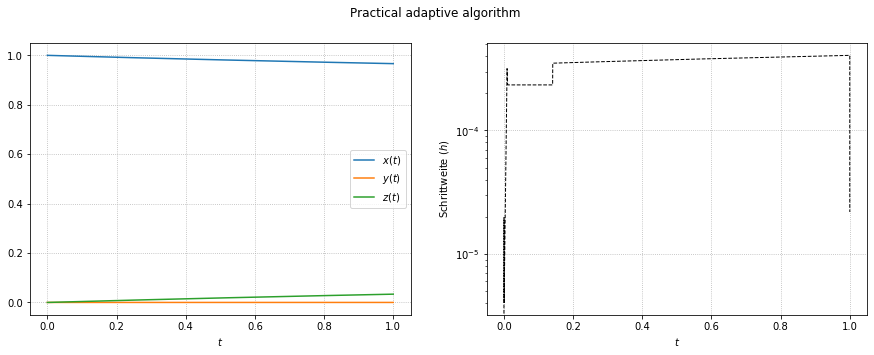

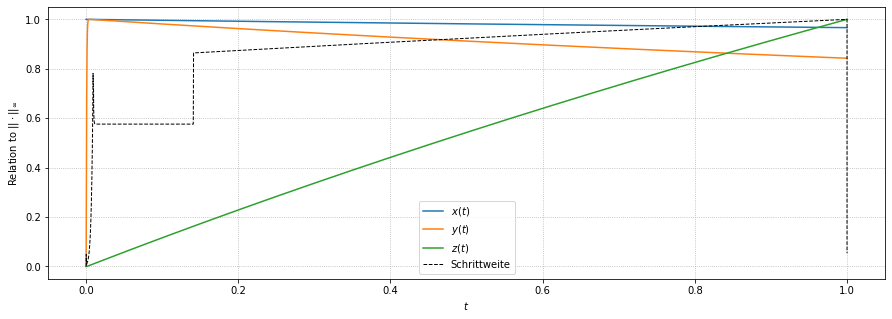

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-13 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec

current status ... 89.67 %
passed time ...... 1 sec



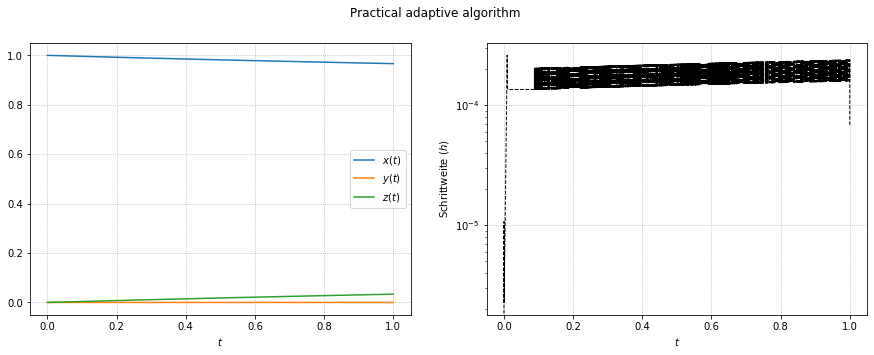

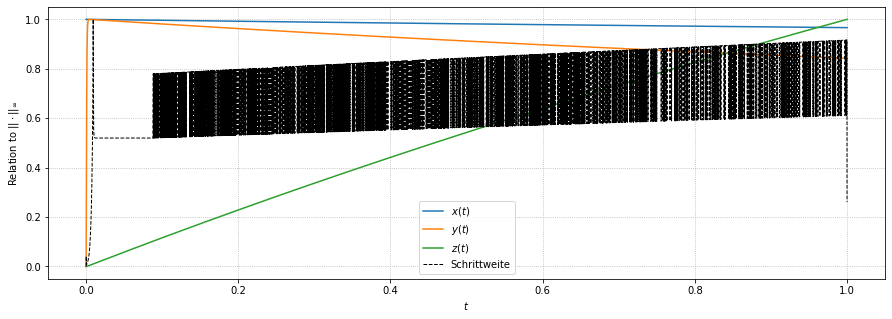

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-14 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec

current status ... 30.01 %
passed time ...... 1 sec

current status ... 81.92 %
passed time ...... 2 sec



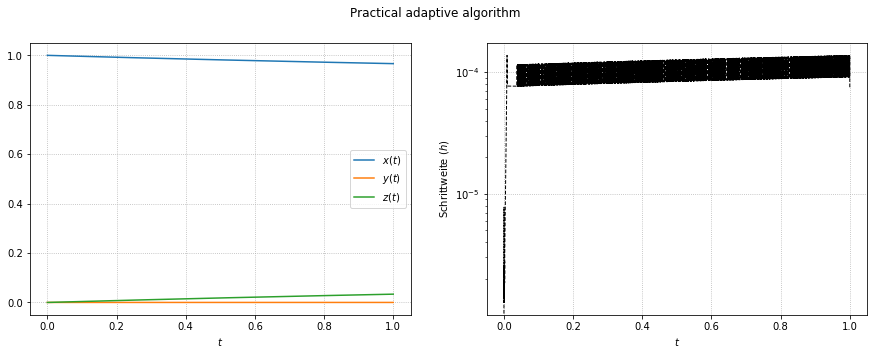

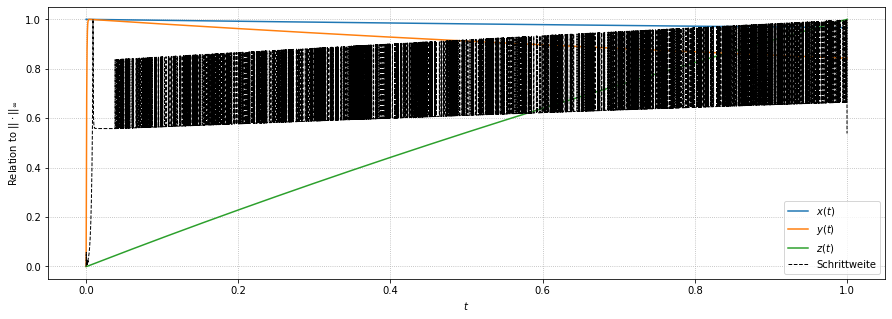

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-15 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec

current status ... 24.05 %
passed time ...... 1 sec

current status ... 63.76 %
passed time ...... 2 sec



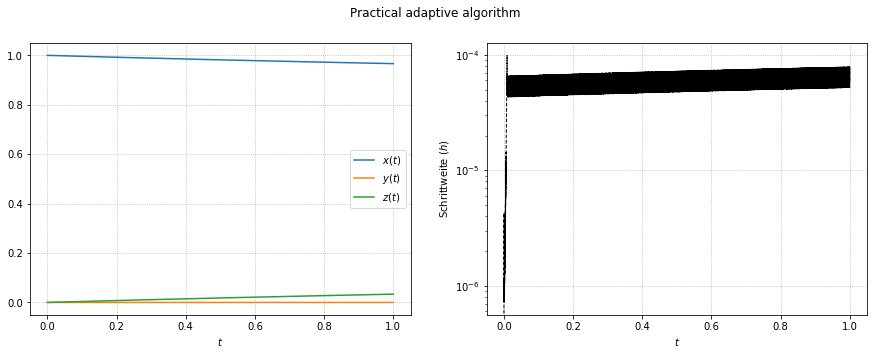

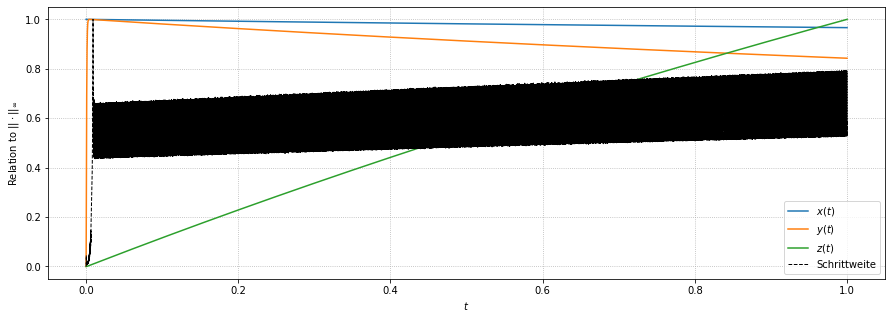

# ---------------------------------------------------------------- # 

# ---------------------------------------------------------------- # 

applying practical adaptive algorithm with tolerance 1e-16 ... 

initiating practical adaptive algorithm ... 

current status ... 0.0 %
current time ..... 0 sec



C:\Users\richa\Anaconda3\lib\site-packages\ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in double_scalars


current status ... 3.6 %
passed time ...... 1 sec

current status ... 28.09 %
passed time ...... 2 sec

current status ... 50.73 %
passed time ...... 3 sec

current status ... 75.62 %
passed time ...... 4 sec



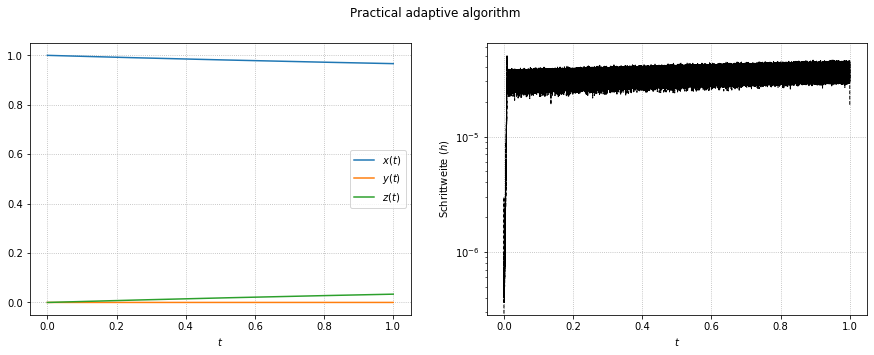

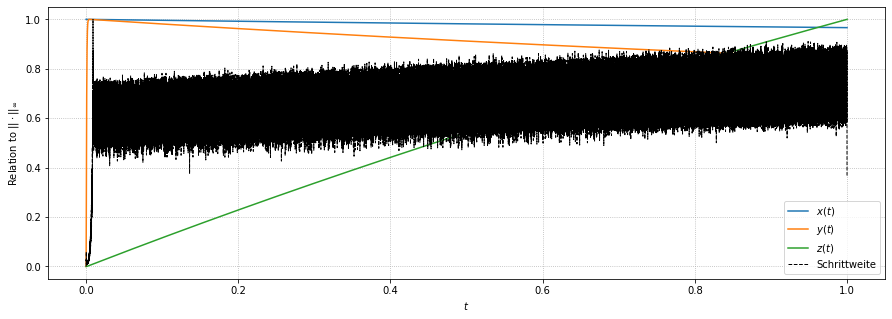

# ---------------------------------------------------------------- # 



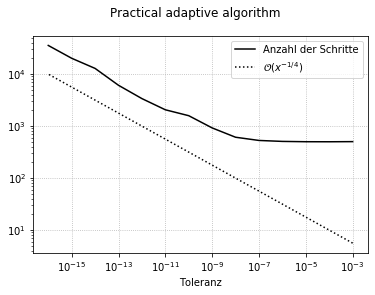

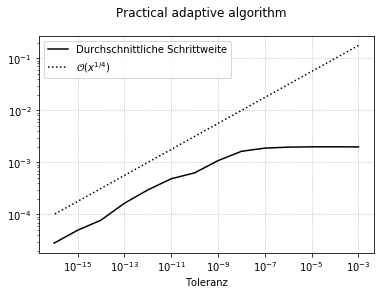

In [5]:
p_min = 3
p_max = 16
p_len = p_max - p_min + 1

tol = np.array([10**(-p) for p in range(p_min, p_max+1)])
step_amount = np.zeros((p_len))
average_step_length = np.zeros((p_len))

for i in range(p_len):

    print('#', '-'*64, '#', '\n')
    print("applying practical adaptive algorithm with tolerance", tol[i], "...", "\n")

    h = apply_practical_adaptive_algorithm(f, y_0, tol[i])
    step_amount[i] = len(h)
    average_step_length[i] = np.average(h)

    print('#', '-'*64, '#', '\n')

# ---------------- #

# plot tolerance vs. step amount

plt.loglog(tol, step_amount, label = "Anzahl der Schritte",        color = 'black')
plt.loglog(tol, tol**(-1/4), label = "$\mathcal{{O}}(x^{{-1/4}})$", color = 'black', linestyle = ':')

plt.xlabel("Toleranz")
plt.legend()
plt.grid(linestyle = ':')
plt.suptitle("Practical adaptive algorithm")

plt.savefig("images" + "/" + "apply_practical_adaptive_algorithm - tolerance_vs_step_amount.png")
plt.show()

# ---------------- #

# plot tolerance vs. average step length

plt.loglog(tol, average_step_length, label = "Durchschnittliche Schrittweite", color = 'black')
plt.loglog(tol, tol**(1/4),         label = "$\mathcal{{O}}(x^{{1/4}})$",     color = 'black', linestyle = ':')

plt.xlabel("Toleranz")
plt.legend()
plt.grid(linestyle = ':')
plt.suptitle("Practical adaptive algorithm")

plt.savefig("images" + "/" + "apply_practical_adaptive_algorithm - tolerance_vs_average_step_length.png")
plt.show()

In [6]:
def apply_implicit_euler(f, f_y, y_0):

    """
        This function applies the implicit Euler-Method.

        f ...... right hand side
        f_y..... derivative with respect to y of right hand side
        y_0 .... initial value at t_0 for solution
    """

    t_0 = 0
    T = 1

    # apparently, this is a good choice ...
    dt = 1e-3

    t = np.arange(t_0, T, dt)

    start = timer()
    y = implicit_euler(t, y_0, f, f_y)
    end = timer()
    print("Runtime for Implicit Euler-Method ...", end - start, "seconds")

    plt.plot(t, y[0], label = "$x(t)$")
    plt.plot(t, y[1], label = "$y(t)$")
    plt.plot(t, y[2], label = "$z(t)$")

    plt.legend()
    plt.xlabel("$t$")

    plt.grid(linestyle = ":")
    plt.suptitle("Implicit Euler-Method")
    plt.show()

Runtime for Implicit Euler-Method ... 0.10685110000000009 seconds


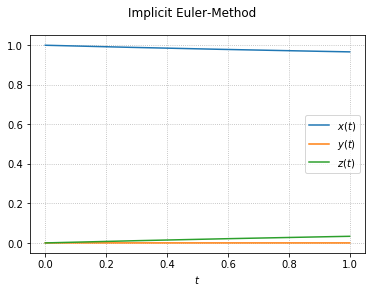

In [7]:
# we do not require this parameter, since we are using fsolve
f_y = None

apply_implicit_euler(f, f_y, y_0)

In [8]:
def explicit_RK4(t, y_0, f):

    """
        This function implements the explicit RK4-Method.

        t ..... time steps
        y_0 ... initial value at t_0 for solution
        f ..... right hand side
    """
    
    # Butcher-Tabelau
    c = np.array([0, 1/2, 1/2, 1])
    A = np.array([[0,   0,   0, 0],
                  [1/2, 0,   0, 0],
                  [0,   1/2, 0, 0],
                  [0,   0,   1, 0]])
    b = np.array([1/6, 1/3, 1/3, 1/6])
    m = len(c)
    
    # dimension of range of f
    n = len(y_0)

    # t = t_0, ..., t_N
    N = len(t) - 1

    # distance between time steps
    h = t[1::] - t[:-1:]

    # approximated solution
    y = np.zeros((N+1, n))
    y[0] = y_0

    for ell in range(N):

        k = np.zeros((m, n))
        k[0] = f(t[ell] + c[0] * h[ell], y[ell])

        for i in range(1, m):

            t_arg = t[ell] + c[i] * h[ell]
#             print("len(A[:, i]) =", len(A[i, :i:]))
#             print("len(k[:i:]) =", len(k[:i:]))
            y_arg = y[ell] + h[ell] * (A[i, :i:] @ k[:i:])

            k[i]   = f(t_arg, y_arg)

        y[ell+1] = y[ell] + h[ell] * (b @ k)

    y = y.transpose()
        
    return y

In [9]:
def apply_explicit_RK4(y_0, f):

    """
        This function applies the explicit RK4-Method.

        f ...... right hand side
        y_0 .... initial value at t_0 for solution
    """

    t_0 = 0
    T = 1

    # apparently, this is a good choice ...
    dt = 1e-3

    t = np.arange(t_0, T, dt)

    start = timer()
    y = explicit_RK4(t, y_0, f)
    end = timer()
    print("Runtime for Explicit RK4-Method ...", end - start, "seconds")

    plt.plot(t, y[0], label = "$x(t)$")
    plt.plot(t, y[1], label = "$y(t)$")
    plt.plot(t, y[2], label = "$z(t)$")

    plt.legend()
    plt.xlabel("$t$")

    plt.grid(linestyle = ":")
    plt.suptitle("Explicit RK4-Method")
    plt.show()

Runtime for Explicit RK4-Method ... 0.07436009999999982 seconds


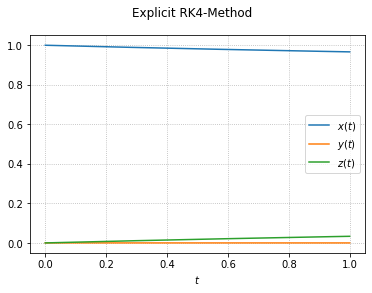

In [10]:
apply_explicit_RK4(y_0, f)